In [ ]:
# session initialization 

In [1]:
rm(list=ls())
Sys.setlocale(category = "LC_ALL",locale = "English_United States.1252")

[1] "LC_COLLATE=English_United States.1252;LC_CTYPE=English_United States.1252;LC_MONETARY=English_United States.1252;LC_NUMERIC=C;LC_TIME=English_United States.1252"

In [2]:
library(openxlsx)
library(dplyr)
library(ggplot2)
library(party)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: grid
Loading required package: mvtnorm
Loading required package: modeltools
Loading required package: stats4
Loading required package: strucchange
Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Loading required package: sandwich


In [ ]:
#load data file and do necessary transformation to generate dataframe df.factor

In [3]:
filepath <- 'C:/Users/aliso/Desktop/study/'
filename <- 'Lead Data Analyst.xlsx'
df <- read.xlsx(paste(filepath,filename,sep=""),sheet=1,colNames=T)

In [4]:
str(df)

'data.frame':	155988 obs. of  18 variables:
 $ weeknumberbyyear          : chr  "2016-01" "2016-01" "2016-01" "2016-01" ...
 $ TrafficSourceType         : chr  "Affiliates" "Affiliates" "Affiliates" "Affiliates" ...
 $ Device                    : chr  "Desktop" "Desktop" "Desktop" "Desktop" ...
 $ VisitorType               : chr  "New" "New" "New" "New" ...
 $ NonBounceVisit            : chr  "Yes" "Yes" "Yes" "Yes" ...
 $ HomePageWasVisited        : chr  "No" "No" "No" "No" ...
 $ ProductPageWasVisited     : chr  "No" "No" "Yes" "Yes" ...
 $ VisitToProductAfterListing: chr  "No" "No" "No" "No" ...
 $ SiteSearchWasUsed         : chr  "No" "No" "No" "No" ...
 $ VisitWithAddtoBag         : chr  "No" "Yes" "No" "No" ...
 $ VisitWithAddtoWishlist    : chr  "No" "No" "No" "No" ...
 $ ShippingAddressWasVisited : chr  "No" "No" "No" "No" ...
 $ PaymentPageWasVisited     : chr  "No" "No" "No" "Yes" ...
 $ ReviewOrderPageWasVisited : chr  "No" "No" "No" "No" ...
 $ ConfirmationPageWasVisited: c

In [5]:
dim(df)

[1] 155988     18

In [6]:
idx.num <- which(sapply(df,is.numeric))
idx.char <- which(sapply(df,is.character))
names(idx.num)
names(idx.char)

## note:
## data structure: 3 numeric variables & 15 char variables; 15 char incl. 14 factors and 1 weekdate; will add 3 derived variables: week, CoR, AoV

[1] "Visits"  "Revenue" "Orders"

[1] "weeknumberbyyear"           "TrafficSourceType"         
 [3] "Device"                     "VisitorType"               
 [5] "NonBounceVisit"             "HomePageWasVisited"        
 [7] "ProductPageWasVisited"      "VisitToProductAfterListing"
 [9] "SiteSearchWasUsed"          "VisitWithAddtoBag"         
[11] "VisitWithAddtoWishlist"     "ShippingAddressWasVisited" 
[13] "PaymentPageWasVisited"      "ReviewOrderPageWasVisited" 
[15] "ConfirmationPageWasVisited"

In [7]:
df.factor <-df

In [8]:
# define factor
for (i in (2:4)){
        x<-names(idx.char)[i]
        df.factor[,x] <- factor(df.factor[,x])
}

for (i in (5:15)){
        x<-names(idx.char)[i]
        df.factor[,x]<- ifelse(df.factor[,x]=="No",0,1)
        df.factor[,x] <- factor(df.factor[,x],levels=c(0,1),labels=c("No","Yes"))
}

In [9]:
#create derived variables CoR, AoV
df.factor$week<-ifelse(df.factor$weeknumberbyyear=="2017-01",54,as.numeric(substr(df.factor$weeknumberbyyear,6,7)))
df.factor$CoR <- df.factor$Orders/df.factor$Visits
df.factor$AoV <- df.factor$Revenue/df.factor$Orders

In [10]:
str(df.factor)

'data.frame':	155988 obs. of  21 variables:
 $ weeknumberbyyear          : chr  "2016-01" "2016-01" "2016-01" "2016-01" ...
 $ TrafficSourceType         : Factor w/ 8 levels "Affiliates","Direct",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Device                    : Factor w/ 3 levels "Desktop","Mobile",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ VisitorType               : Factor w/ 2 levels "New","Returning": 1 1 1 1 1 1 1 1 1 1 ...
 $ NonBounceVisit            : Factor w/ 2 levels "No","Yes": 2 2 2 2 2 2 2 2 2 2 ...
 $ HomePageWasVisited        : Factor w/ 2 levels "No","Yes": 1 1 1 1 1 1 1 1 1 1 ...
 $ ProductPageWasVisited     : Factor w/ 2 levels "No","Yes": 1 1 2 2 2 2 2 2 2 2 ...
 $ VisitToProductAfterListing: Factor w/ 2 levels "No","Yes": 1 1 1 1 1 1 1 1 1 1 ...
 $ SiteSearchWasUsed         : Factor w/ 2 levels "No","Yes": 1 1 1 1 1 1 1 1 2 2 ...
 $ VisitWithAddtoBag         : Factor w/ 2 levels "No","Yes": 1 2 1 1 1 2 2 2 1 2 ...
 $ VisitWithAddtoWishlist    : Factor w/ 2 levels "No","Yes": 1 1 1 1 

In [11]:
dim(df.factor)

[1] 155988     21

In [12]:
c(54 * 8 * 3 * 2^12,15)

## not all the levels of factors will appear per week

[1] 5308416      15

In [ ]:
#data explore

In [13]:
#user function
mySummary <- function(x){
    summary(df.factor[,x])
}
myHist <- function(x) {
    hist(df.factor[,x],main=NULL,xlab=x,breaks=50)
}

myBoxplot <- function(x) {
    boxplot(df.factor[,x],main=NULL,xlab=x)
}
myTable <- function(x){
    V <- sort(100* round(prop.table(xtabs(Visits~df.factor[,x],df.factor)),digits=4),decreasing=T) # Visits, Orders, Revenue
    O <- sort(100* round(prop.table(xtabs(Orders~df.factor[,x],df.factor)),digits=4),decreasing=T)
    R <- sort(100* round(prop.table(xtabs(Revenue~df.factor[,x],df.factor)),digits=4),decreasing=T)
    print(x)
    print("Visits:");print(V)
    print("Orders");print(O)
    print("Revenue:");print(R)
}
myPie <- function(x,y){
    myPt <- 100 * round(prop.table(xtabs(df.factor[,y]~df.factor[,x],df.factor)),digits=4) # Visits, Orders, Revenue
    myLabels <- paste(names(myPt),"\n",myPt,"%",sep="")
    pie(myPt,labels=myLabels,cex=.8,main=y)
}

In [14]:
sapply(names(idx.num),mySummary)

## note:
## every row has min. 1 visits
## all the 3 numberic variables are higly skewed

,Visits,Revenue,Orders
Min.,1.0000,0.000,0.000000
1st Qu.,1.0000,0.000,0.000000
Median,2.0000,0.000,0.000000
Mean,227.4854,1595.634,2.098226
3rd Qu.,10.0000,261.588,1.000000
Max.,58182.0000,1348614.689,1605.000000


In [15]:
cor(df[,idx.num])

## note:
## Orders and Revenue are corelated in a high degree
## all 3 are positive related

,Visits,Revenue,Orders
Visits,1.00000000,0.08378724,0.1230829
Revenue,0.08378724,1.00000000,0.9368868
Orders,0.12308293,0.93688683,1.0000000


In [16]:
sapply(names(idx.char),myTable) 

## note:
## figure out 3 variables are 100% linking to order/revenue
## NonBounceVisit: Yes - 100% Orders=0, Revenue=0
## ReviewOrderPageWasVisited: No - 100% Orders=0, Revenue=0
## ConfirmationPageWasVisited: No - 100% Orders=0, Revenue=0

[1] "weeknumberbyyear"
[1] "Visits:"
df.factor[, x]
2016-48 2016-49 2016-51 2016-50 2016-41 2017-01 2016-44 2016-26 2016-25 2016-30 
   4.72    3.21    2.71    2.47    2.36    2.16    2.15    2.14    2.13    2.08 
2016-43 2016-21 2016-28 2016-22 2016-45 2016-52 2016-46 2016-42 2016-35 2016-13 
   2.05    2.00    1.99    1.98    1.98    1.98    1.97    1.96    1.95    1.93 
2016-29 2016-31 2016-02 2016-20 2016-47 2016-32 2016-27 2016-14 2016-40 2016-33 
   1.92    1.87    1.86    1.86    1.85    1.82    1.80    1.77    1.76    1.75 
2016-38 2016-39 2016-03 2016-07 2016-23 2016-24 2016-15 2016-36 2016-12 2016-09 
   1.75    1.75    1.73    1.71    1.70    1.69    1.66    1.66    1.64    1.60 
2016-16 2016-04 2016-10 2016-08 2016-11 2016-37 2016-05 2016-06 2016-18 2016-34 
   1.60    1.59    1.59    1.58    1.57    1.55    1.53    1.53    1.52    1.51 
2016-17 2016-19 2016-01 
   1.46    1.37    0.54 
[1] "Orders"
df.factor[, x]
2016-48 2016-29 2016-22 2016-49 2016-04 2016-23 2016-51 2016

$weeknumberbyyear
df.factor[, x]
2016-48 2016-49 2016-29 2016-47 2016-50 2016-46 2016-51 2016-22 2016-04 2016-23 
   7.07    3.51    3.28    3.18    3.08    2.79    2.79    2.70    2.63    2.37 
2016-06 2016-20 2016-43 2016-27 2016-44 2016-21 2016-26 2016-24 2016-45 2016-52 
   2.23    2.17    2.12    2.09    2.08    2.06    2.04    2.03    2.00    1.99 
2017-01 2016-40 2016-07 2016-17 2016-41 2016-35 2016-32 2016-25 2016-28 2016-12 
   1.91    1.89    1.84    1.77    1.73    1.70    1.64    1.63    1.59    1.55 
2016-13 2016-16 2016-37 2016-11 2016-34 2016-36 2016-38 2016-19 2016-39 2016-14 
   1.53    1.52    1.48    1.47    1.45    1.37    1.37    1.35    1.28    1.27 
2016-18 2016-33 2016-02 2016-15 2016-03 2016-10 2016-08 2016-30 2016-31 2016-09 
   1.27    1.27    1.26    1.26    1.23    1.23    1.21    1.15    1.12    1.07 
2016-42 2016-05 2016-01 
   1.02    1.00    0.35 

$TrafficSourceType
df.factor[, x]
    Direct    Organic        PPC      Email Affiliates    Display  Refer

In [ ]:
#Business Overview: KPI-define,components,trend,share
#  Present an overview analysis of Farfetch Results in 2016. 
#  Which metrics do you think are relevant to measure Farfetch performance? Enumerate KPIs that can be derived from the database provided and develop an analysis over that KPI. 

In [62]:
#trend
agg <- aggregate(cbind(Visits,Orders,Revenue) ~ weeknumberbyyear,df.factor,sum)

In [63]:
agg$CoR <- round(agg$Orders/agg$Visits,digits=4) *100
agg$AoV <- round(agg$Revenue/agg$Orders,digits=2)
agg$week <- ifelse(agg$weeknumberbyyear=="2017-01",54,as.numeric(substr(agg$weeknumberbyyear,6,7)))

In [64]:
str(agg)

'data.frame':	53 obs. of  7 variables:
 $ weeknumberbyyear: chr  "2016-01" "2016-02" "2016-03" "2016-04" ...
 $ Visits          : num  190621 660281 614301 564557 543870 ...
 $ Orders          : num  1333 4543 4357 8889 3944 ...
 $ Revenue         : num  875549 3138079 3058317 6548814 2486678 ...
 $ CoR             : num  0.7 0.69 0.71 1.57 0.73 1.31 0.99 0.69 0.58 0.71 ...
 $ AoV             : num  657 691 702 737 630 ...
 $ week            : num  1 2 3 4 5 6 7 8 9 10 ...


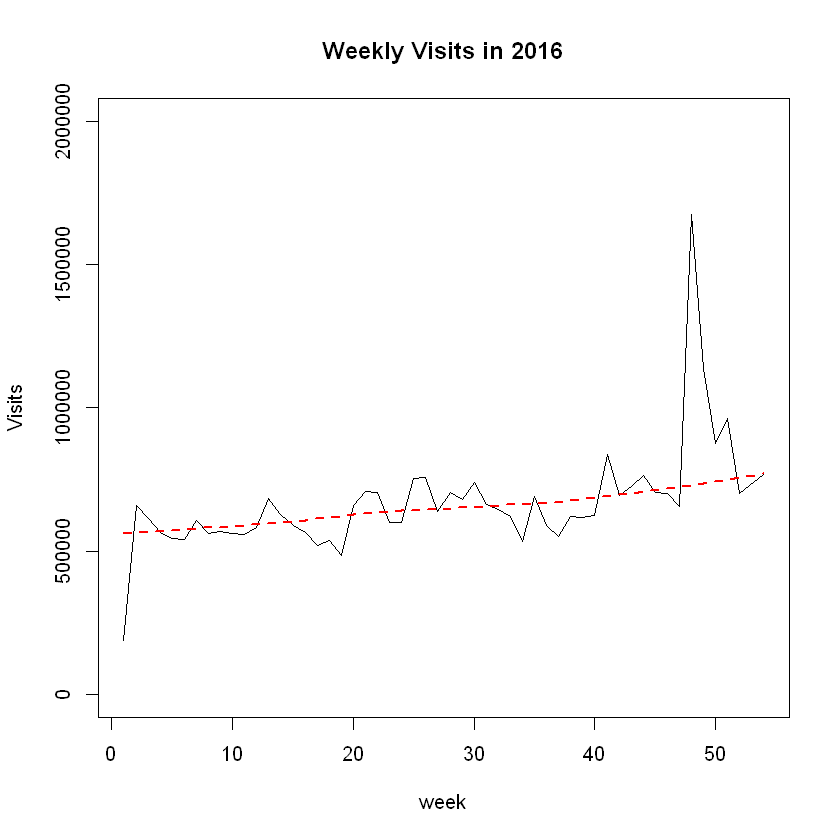

In [65]:
plot(Visits~week,agg,type='l',col=1,lty=1,ylim=c(0,2e+06),main="Weekly Visits in 2016",ylab="Visits")
lines(lowess(agg$week,agg$Visits),col=2,lwd=2,lty=2)

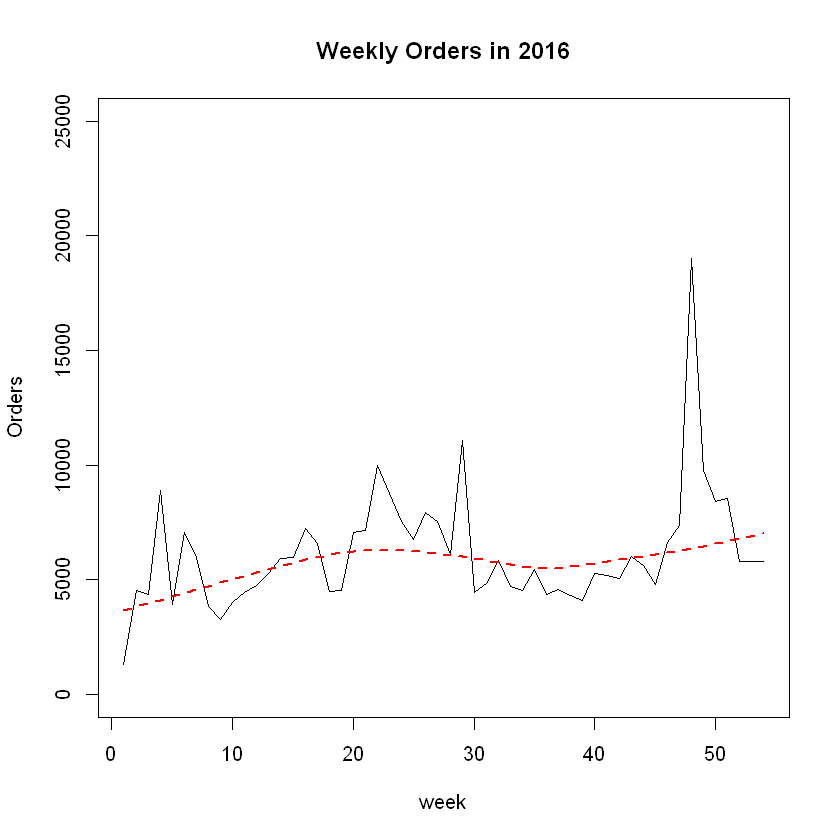

In [66]:
plot(Orders~week,agg,type='l',col=1,lty=1,ylim=c(0,2.5e+04),main="Weekly Orders in 2016",ylab="Orders")
lines(lowess(agg$week,agg$Orders),col=2,lwd=2,lty=2)

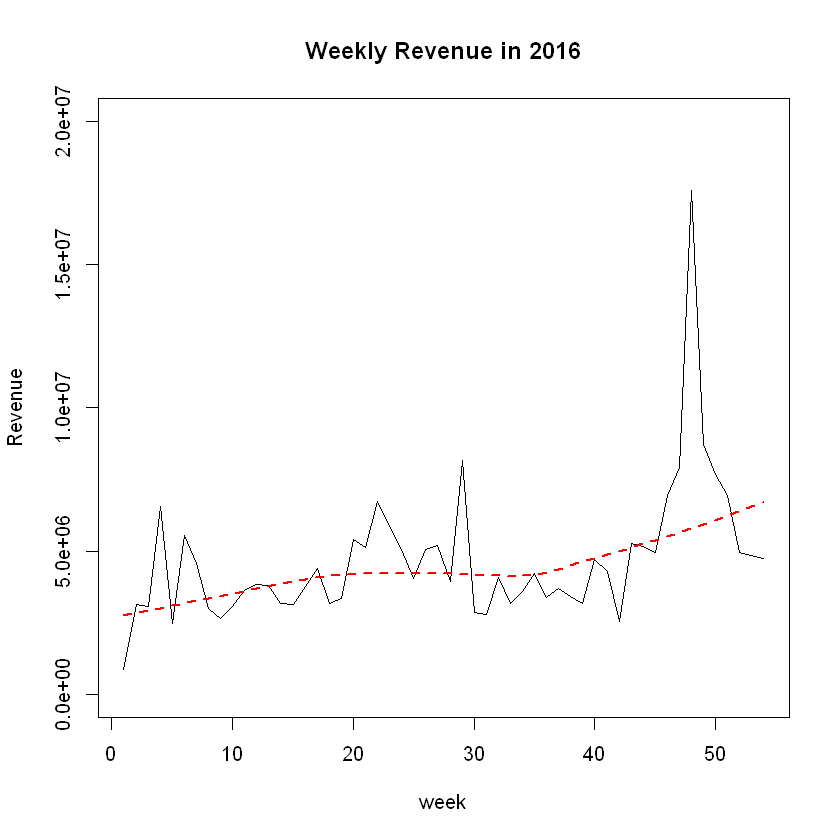

In [67]:
plot(Revenue~week,agg,type='l',col=1,lty=1,ylim=c(0,2e+07),main="Weekly Revenue in 2016",ylab="Revenue")
lines(lowess(agg$week,agg$Revenue),col=2,lwd=2,lty=2)

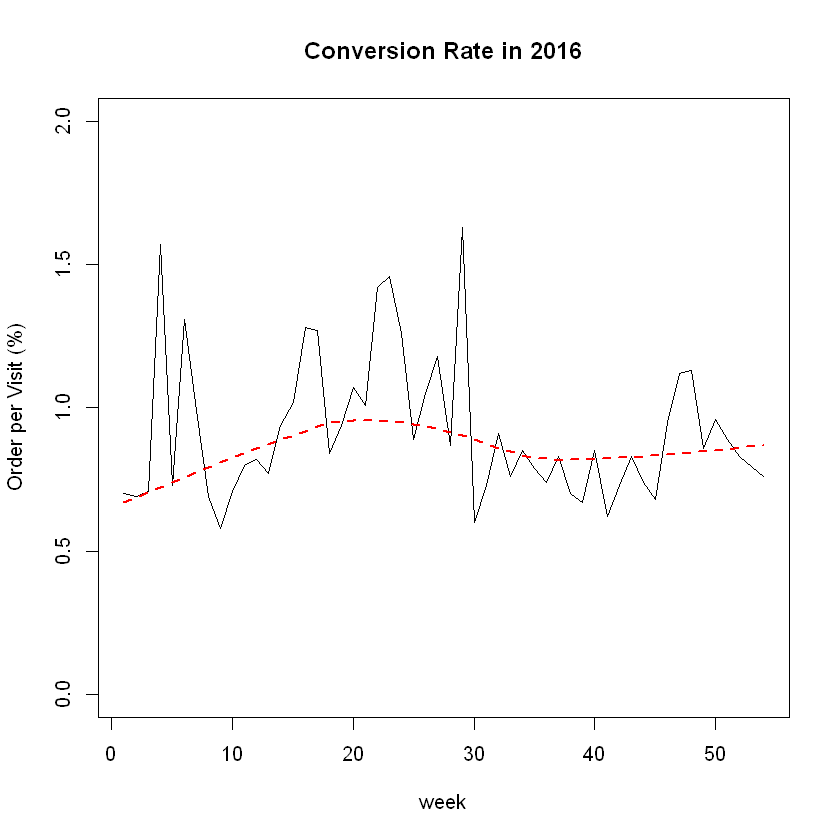

In [68]:
plot(CoR~week,agg,type='l',col=1,lty=1,ylim=c(0,2),main="Conversion Rate in 2016",ylab="Order per Visit (%)")
lines(lowess(agg$week,agg$CoR),col=2,lwd=2,lty=2)

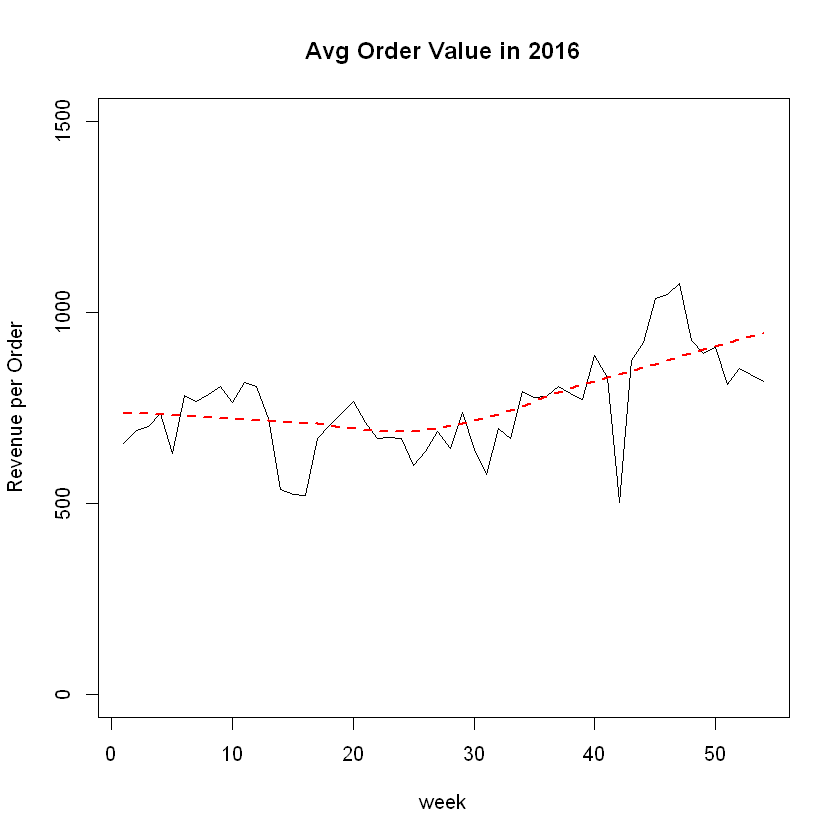

In [69]:
plot(AoV~week,agg,type='l',col=1,lty=1,ylim=c(0,1500),main="Avg Order Value in 2016",ylab="Revenue per Order")
lines(lowess(agg$week,agg$AoV),col=2,lwd=2,lty=2)

In [ ]:
## note:
## all the 5 KPI trend and the lowess lines indicate the 
## Visits, Orders, Revenue went up through the year
## Order Valeus went up through the year
## Conversion Rate kept up in 1/2 year, went down a bit and went flat in the last 1/3 year

In [ ]:
# by TrafficSourceType

In [70]:
agg <- aggregate(cbind(Visits,Orders,Revenue) ~ weeknumberbyyear + TrafficSourceType,df.factor,sum)
agg$CoR <- round(agg$Orders/agg$Visits,digits=4) *100
agg$AoV <- round(agg$Revenue/agg$Orders,digits=2)
agg$week <- ifelse(agg$weeknumberbyyear=="2017-01",54,as.numeric(substr(agg$weeknumberbyyear,6,7)))

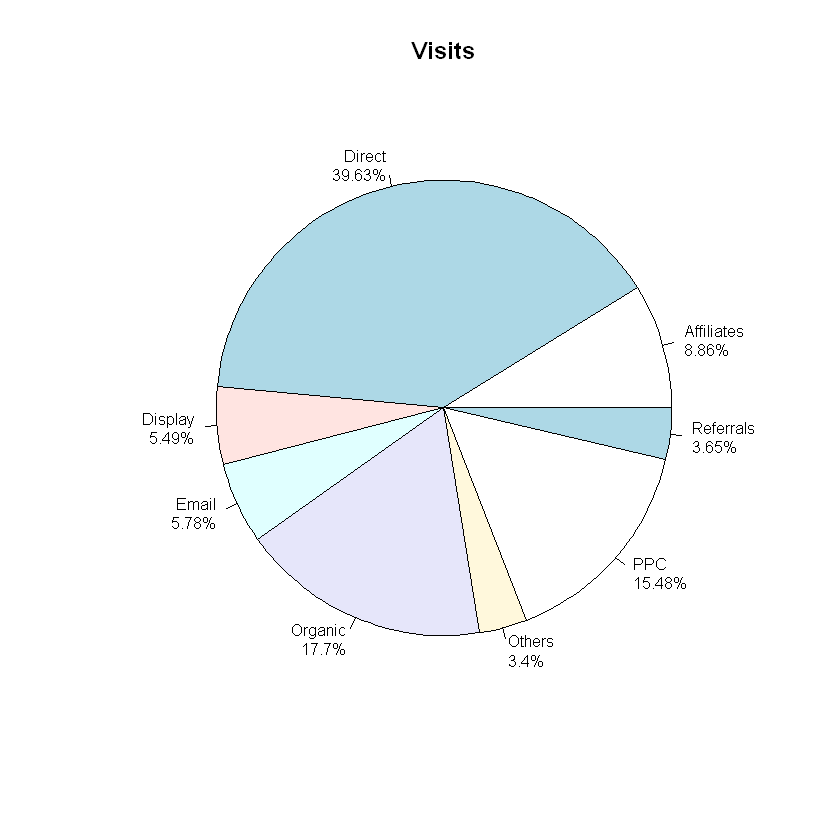

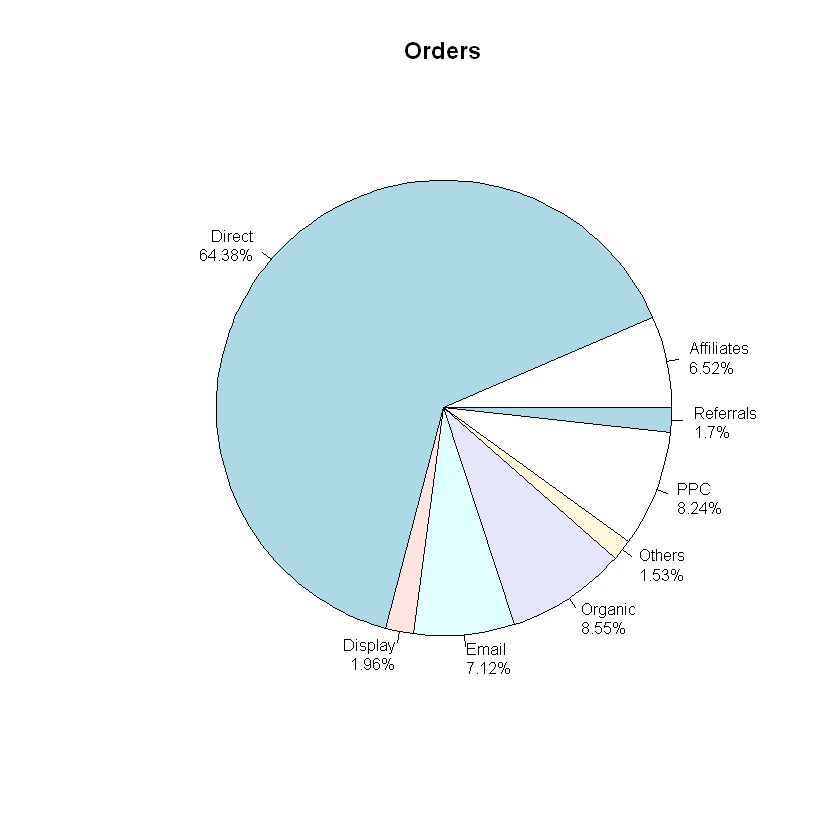

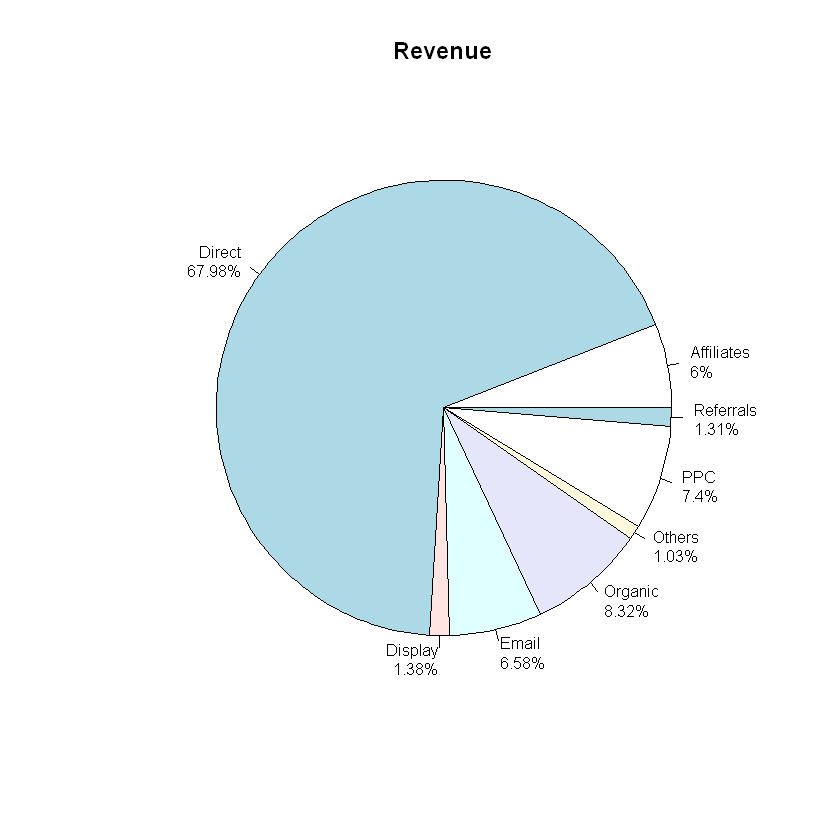

In [71]:
myPie("TrafficSourceType","Visits")
myPie("TrafficSourceType","Orders")
myPie("TrafficSourceType","Revenue")

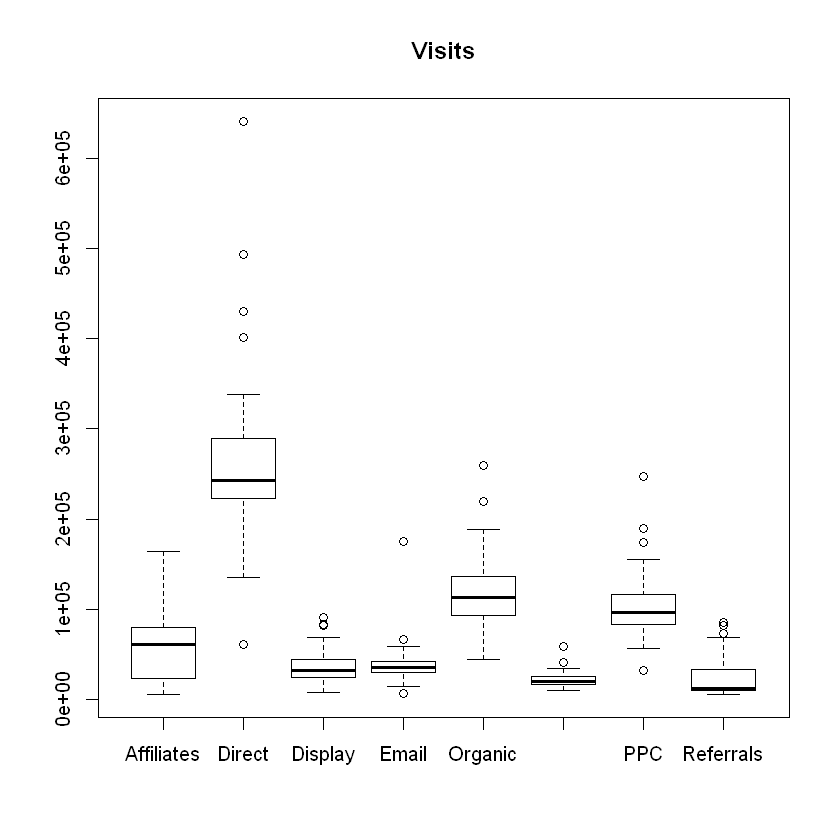

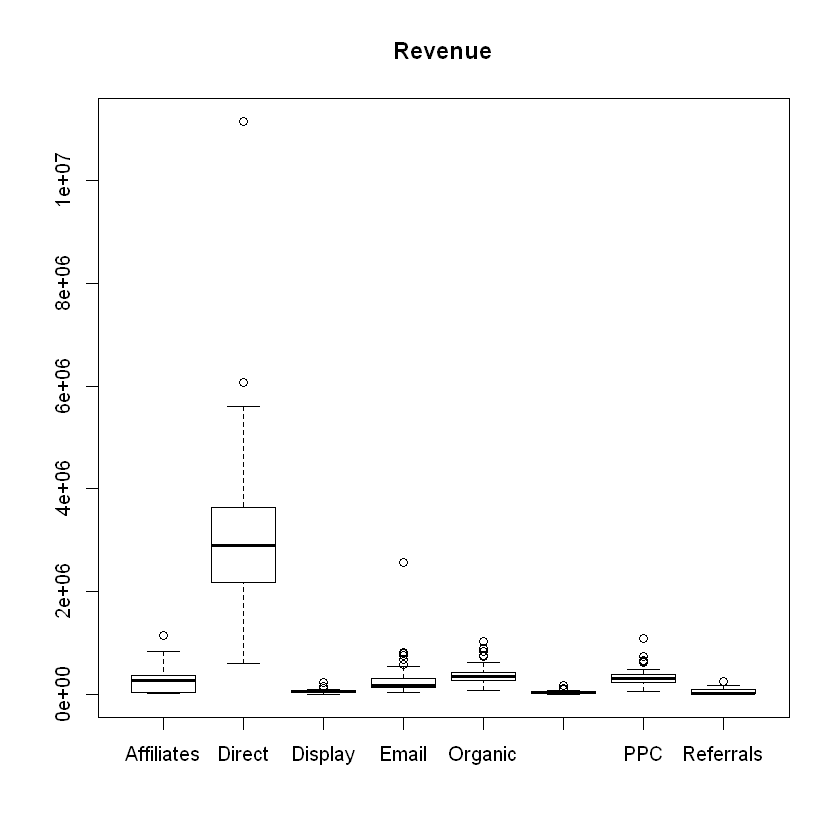

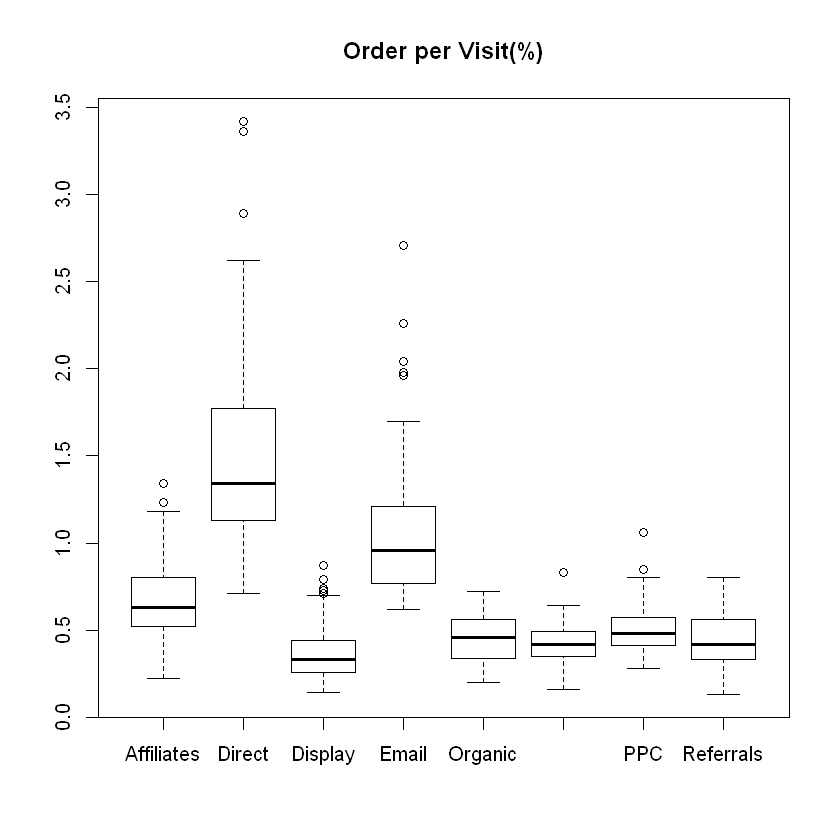

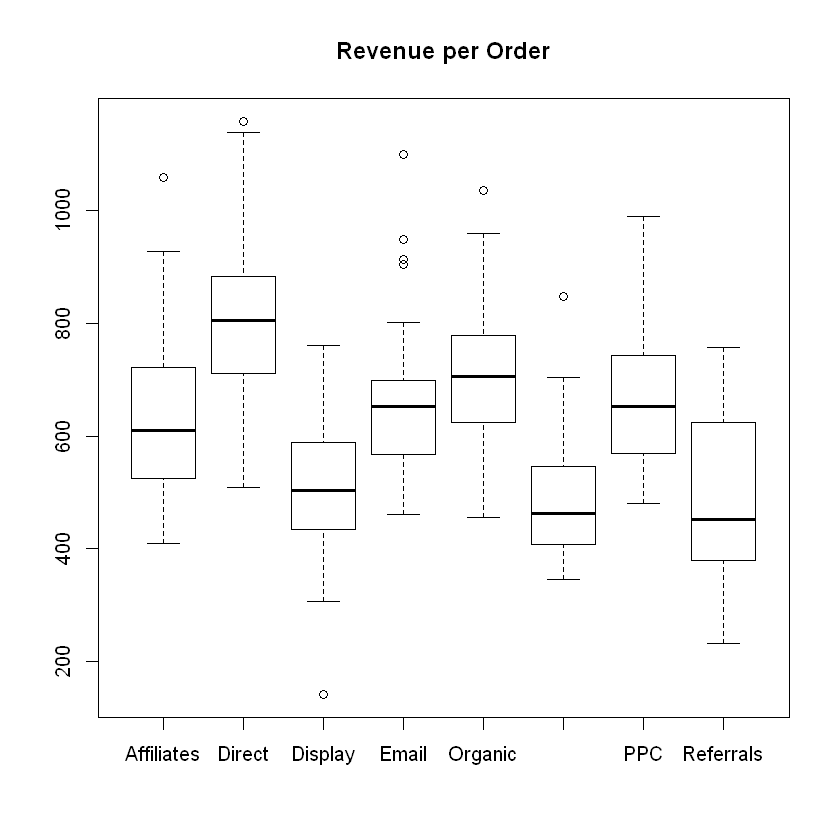

In [72]:
boxplot(Visits~TrafficSourceType,agg,main="Visits")
boxplot(Revenue~TrafficSourceType,agg,main="Revenue")
boxplot(CoR~TrafficSourceType,agg,main="Order per Visit(%)")
boxplot(AoV~TrafficSourceType,agg,main="Revenue per Order")

In [ ]:
## note: 
## TrafficSourceType:Direct is top 1 in all the KPI, it took 40% Visits, 64% Orders, 68% Revenue.
## Next to Direct, Email has high CoR.

In [ ]:
# by Device

In [73]:
agg <- aggregate(cbind(Visits,Orders,Revenue) ~ weeknumberbyyear + Device,df.factor,sum)
agg$CoR <- round(agg$Orders/agg$Visits,digits=4) *100
agg$AoV <- round(agg$Revenue/agg$Orders,digits=2)
agg$week <- ifelse(agg$weeknumberbyyear=="2017-01",54,as.numeric(substr(agg$weeknumberbyyear,6,7)))

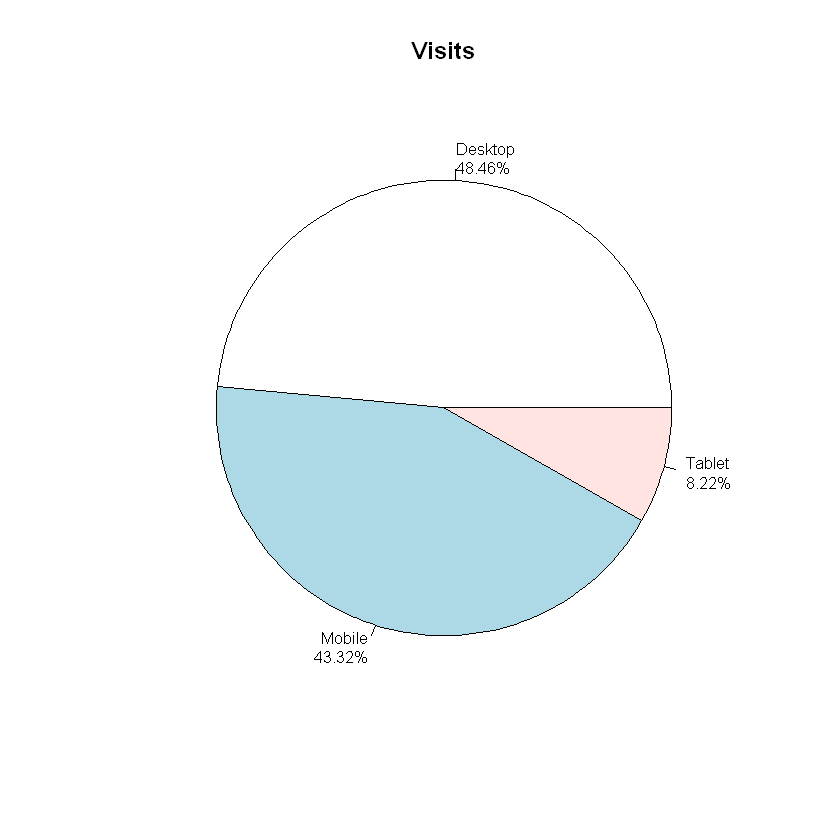

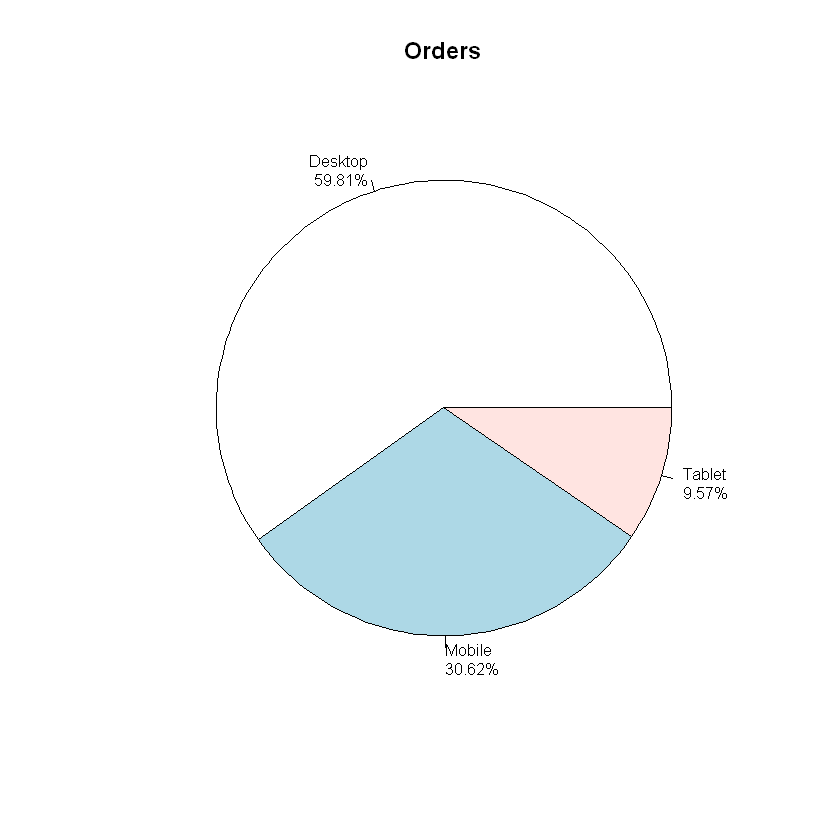

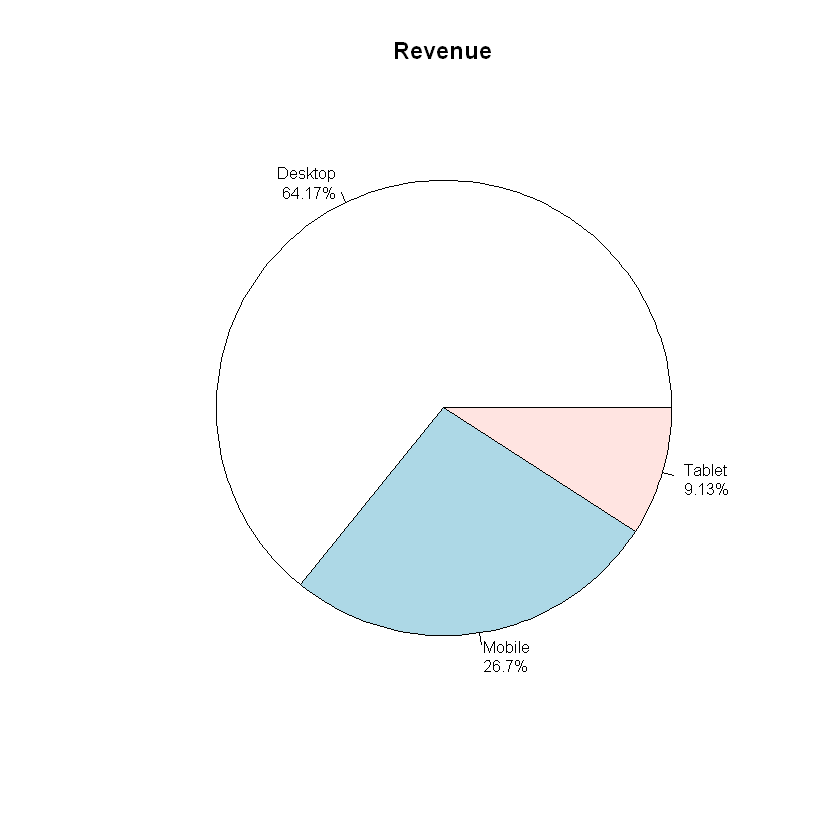

In [74]:
myPie("Device","Visits")
myPie("Device","Orders")
myPie("Device","Revenue")

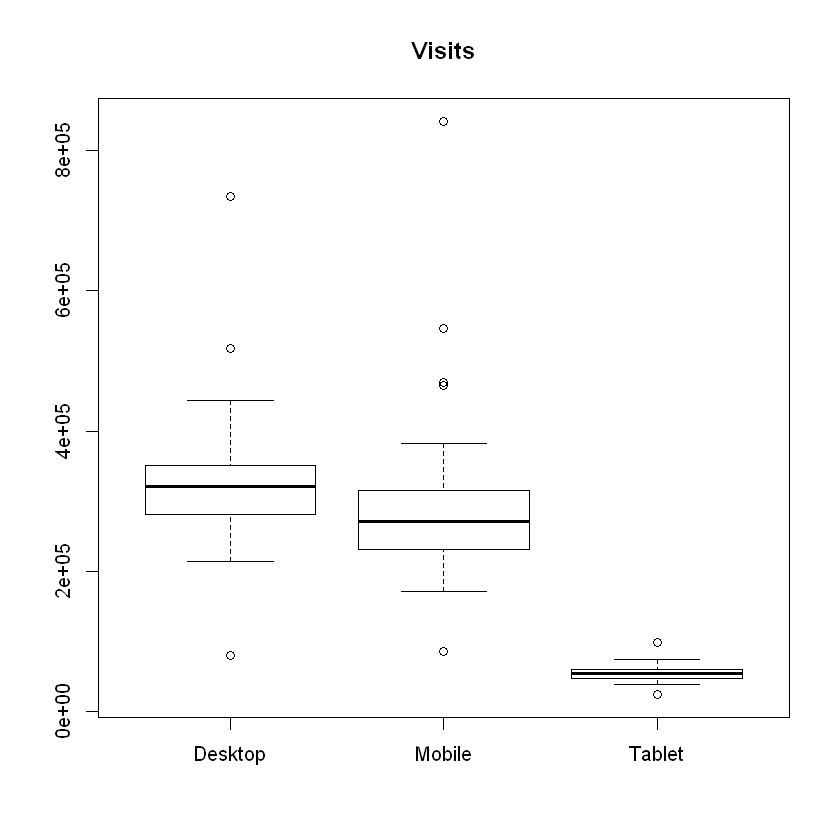

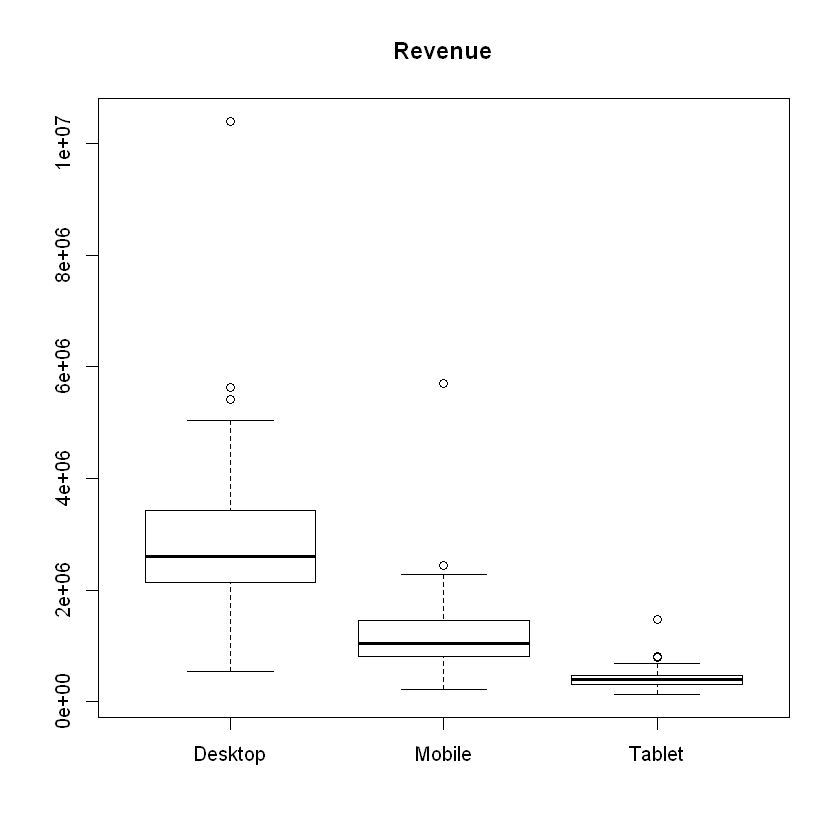

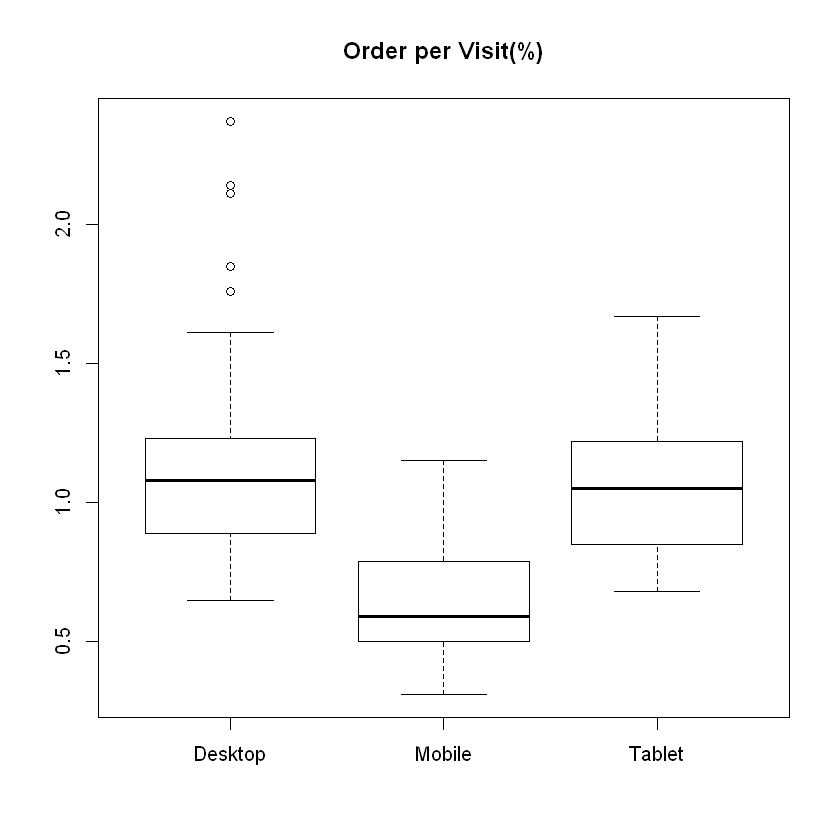

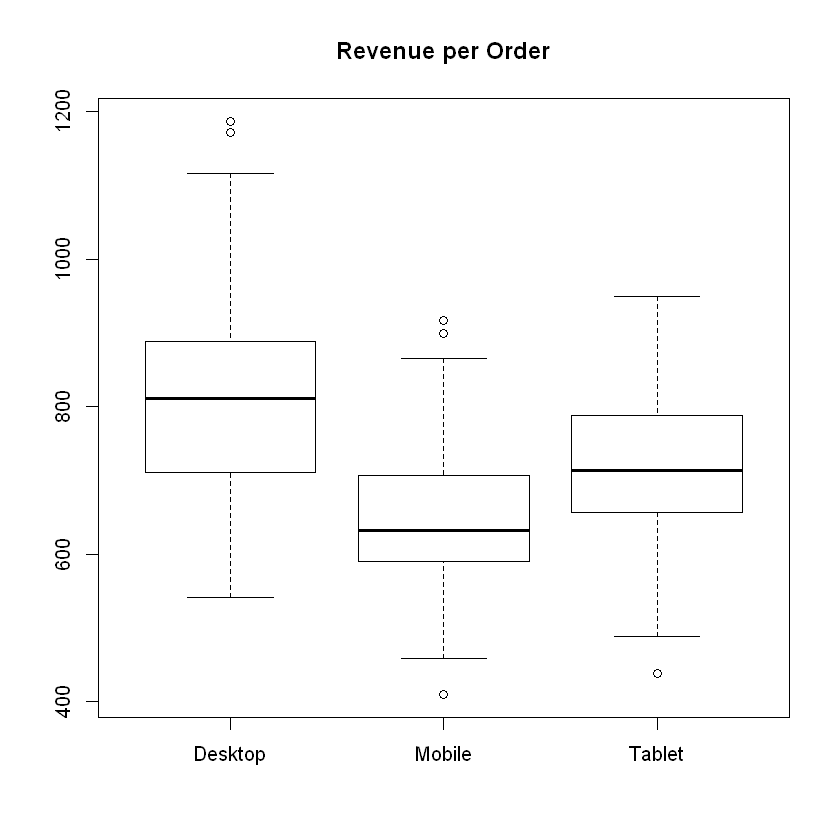

In [75]:
boxplot(Visits~Device,agg,main="Visits")
boxplot(Revenue~Device,agg,main="Revenue")
boxplot(CoR~Device,agg,main="Order per Visit(%)")
boxplot(AoV~Device,agg,main="Revenue per Order")

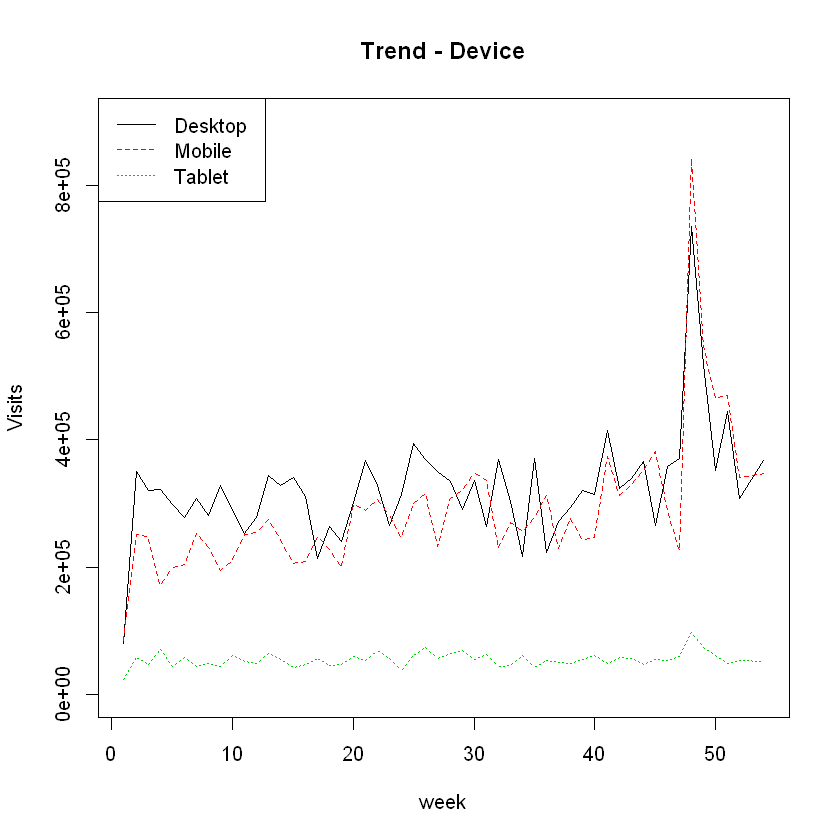

In [76]:
plot(Visits~week,filter(agg,Device=="Desktop"),type='l',col=1,lty=1,ylim=c(0,9e+05),main="Trend - Device",ylab="Visits")
lines(Visits~week,filter(agg,Device=="Mobile"),col=2,lty=2)
lines(Visits~week,filter(agg,Device=="Tablet"),col=3,lty=3)
legend("topleft",col=c(1,2,3),lty=c(1,2,3),c("Desktop"，"Mobile","Tablet"))

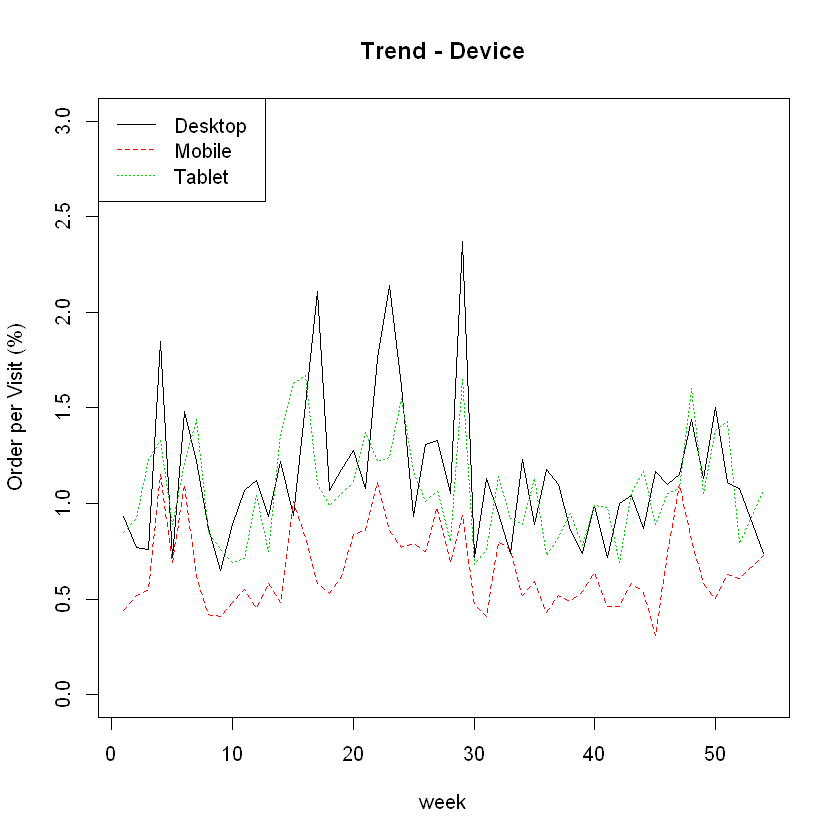

In [77]:
plot(CoR~week,filter(agg,Device=="Desktop"),type='l',col=1,lty=1,ylim=c(0,3),main="Trend - Device",ylab="Order per Visit (%)")
lines(CoR~week,filter(agg,Device=="Mobile"),col=2,lty=2)
lines(CoR~week,filter(agg,Device=="Tablet"),col=3,lty=3)
legend("topleft",col=c(1,2,3),lty=c(1,2,3),c("Desktop"，"Mobile","Tablet"))

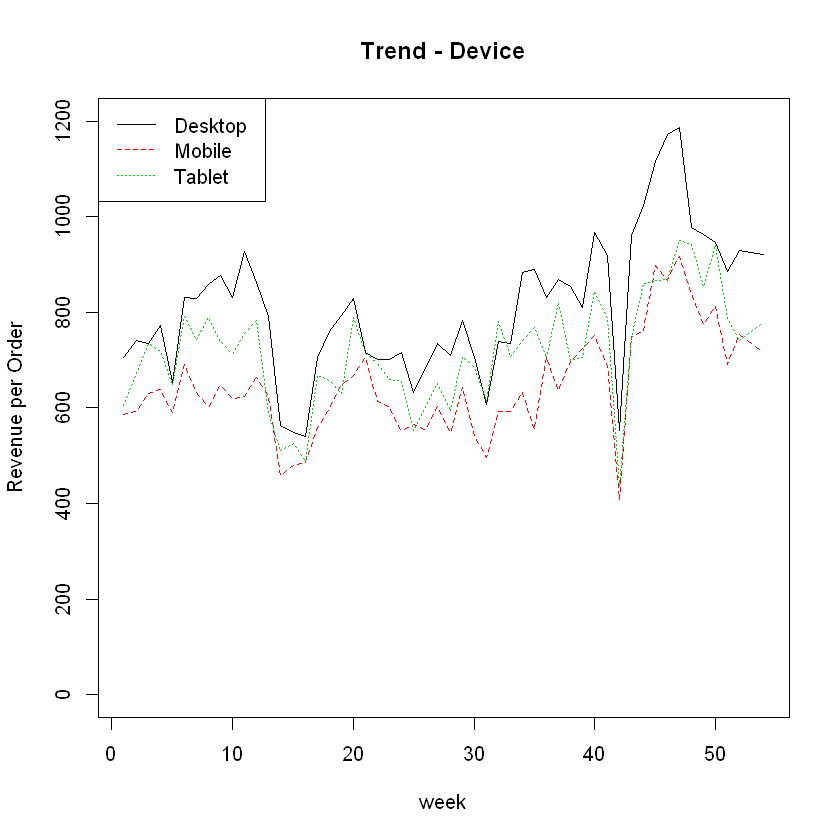

In [78]:
plot(AoV~week,filter(agg,Device=="Desktop"),type='l',col=1,lty=1,ylim=c(0,1200),main="Trend - Device",ylab="Revenue per Order")
lines(AoV~week,filter(agg,Device=="Mobile"),col=2,lty=2)
lines(AoV~week,filter(agg,Device=="Tablet"),col=3,lty=3)
legend("topleft",col=c(1,2,3),lty=c(1,2,3),c("Desktop"，"Mobile","Tablet"))

In [ ]:
## note:
## mobile forked #2 visits, but the CoR, AoV are the bottom.

In [ ]:
# VisitorType

In [80]:
agg <- aggregate(cbind(Visits,Orders,Revenue) ~ weeknumberbyyear + VisitorType,df.factor,sum)
agg$CoR <- round(agg$Orders/agg$Visits,digits=4) *100
agg$AoV <- round(agg$Revenue/agg$Orders,digits=2)
agg$week <- ifelse(agg$weeknumberbyyear=="2017-01",54,as.numeric(substr(agg$weeknumberbyyear,6,7)))

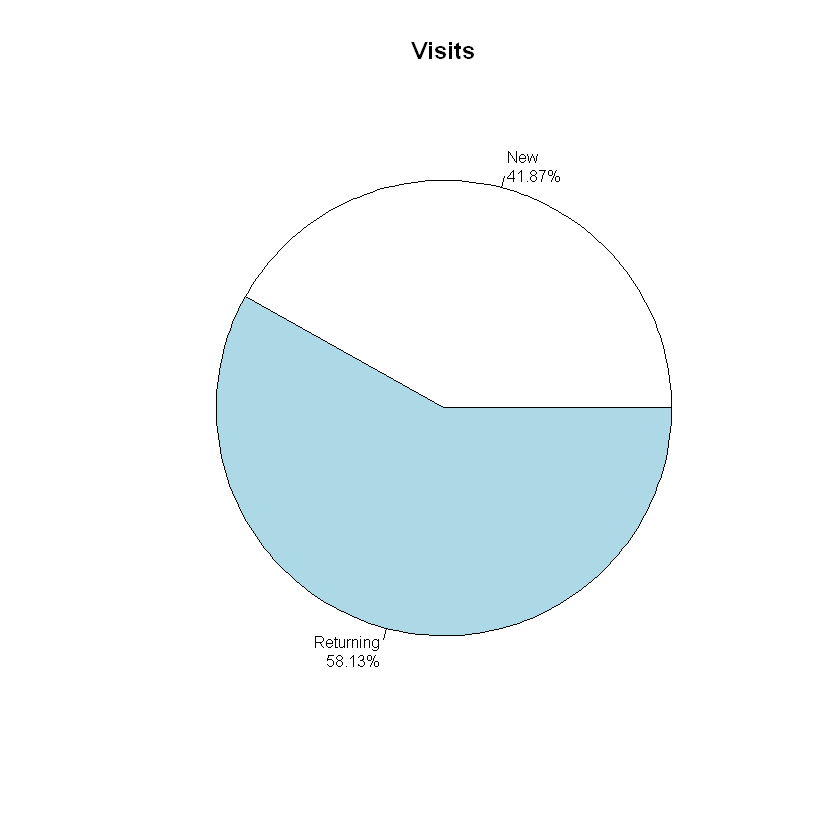

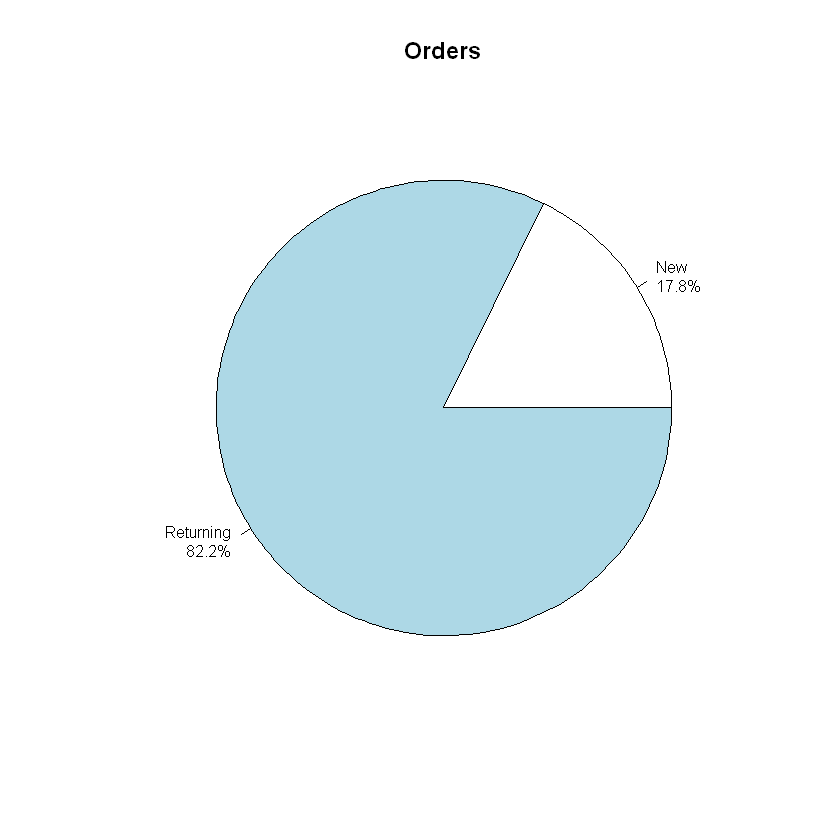

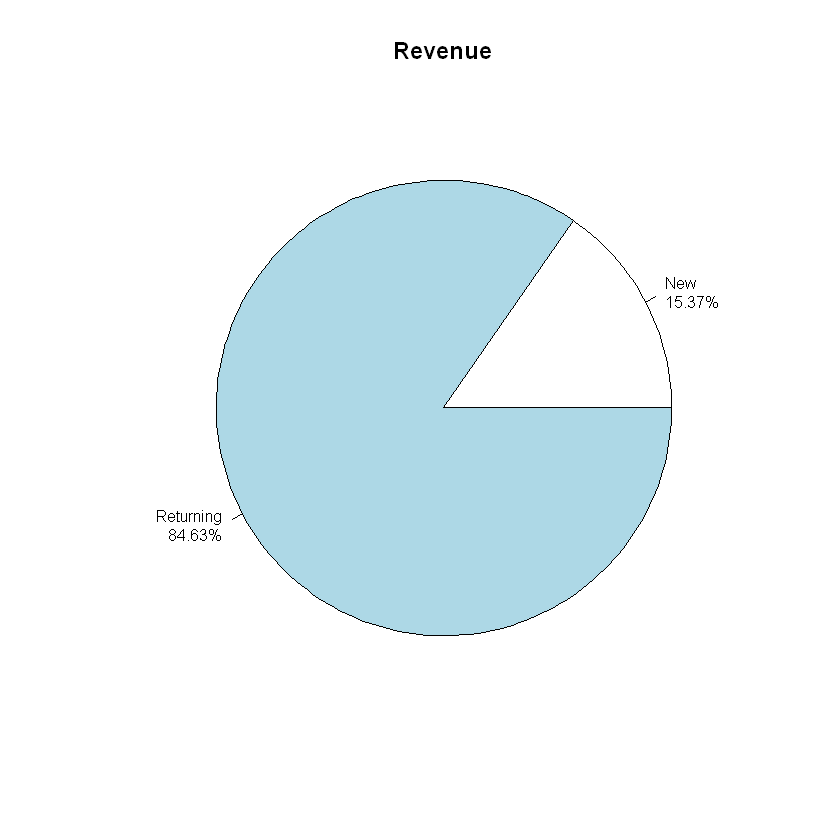

In [81]:
myPie("VisitorType","Visits")
myPie("VisitorType","Orders")
myPie("VisitorType","Revenue")

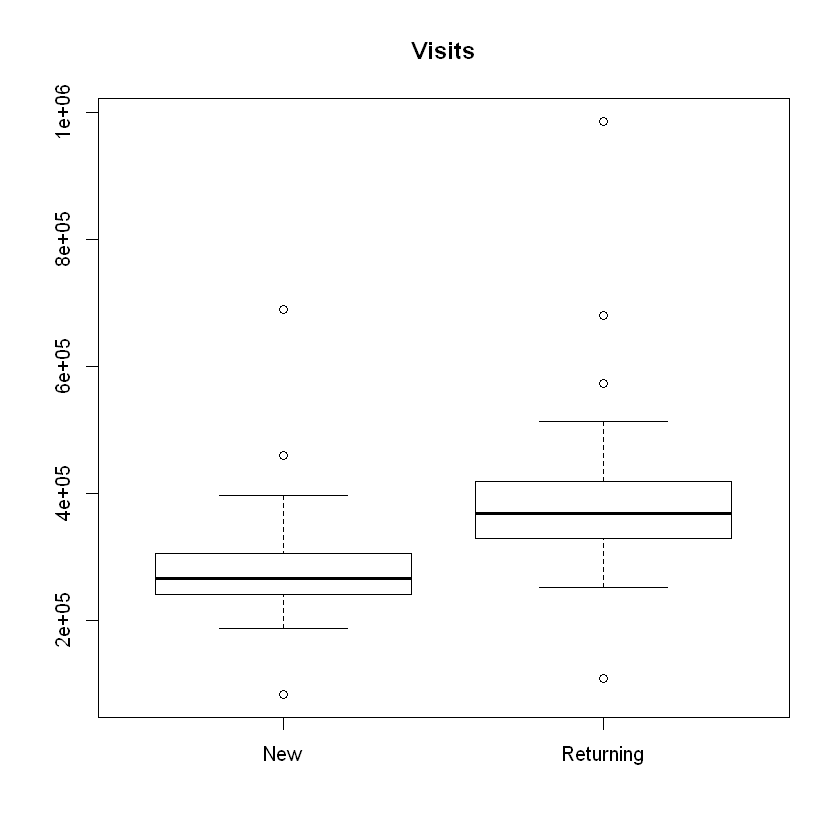

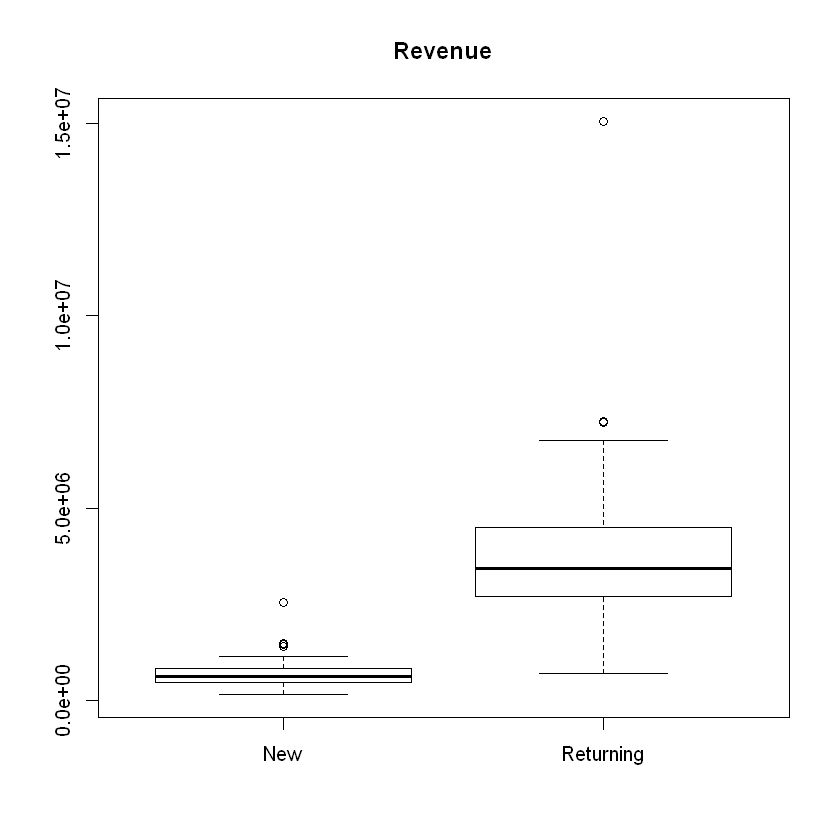

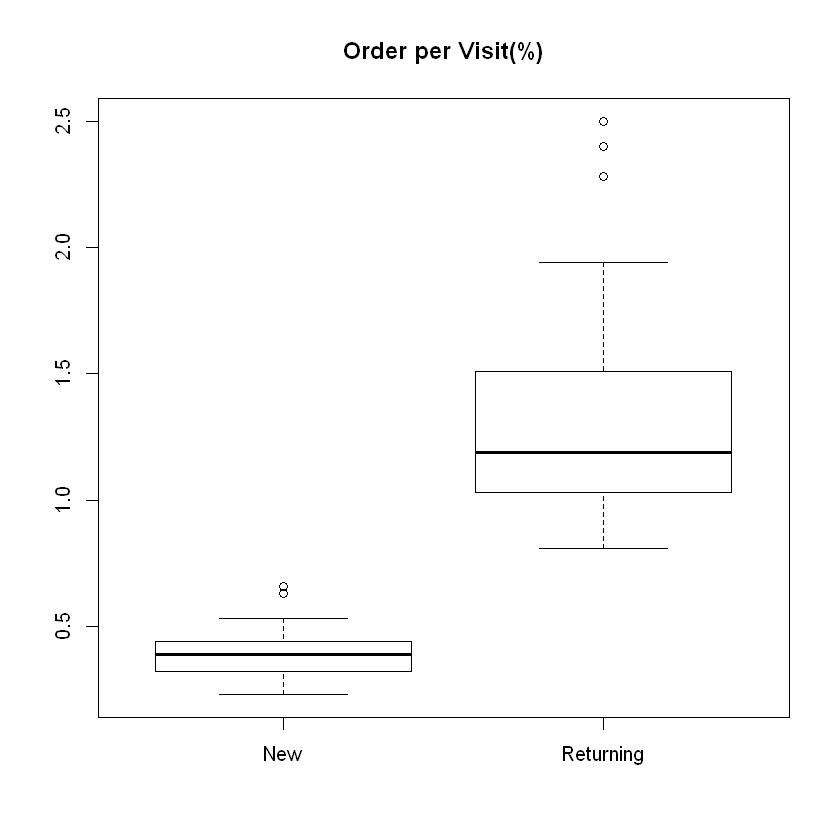

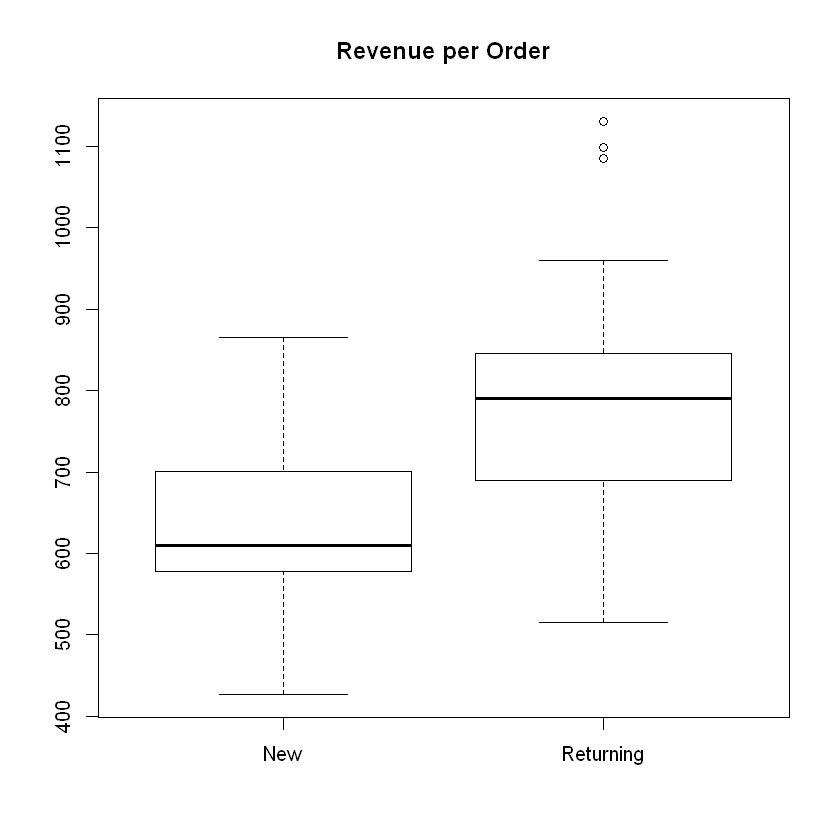

In [82]:
boxplot(Visits~VisitorType,agg,main="Visits")
boxplot(Revenue~VisitorType,agg,main="Revenue")
boxplot(CoR~VisitorType,agg,main="Order per Visit(%)")
boxplot(AoV~VisitorType,agg,main="Revenue per Order")

In [ ]:
## note:
## returning visitor contributed 58% Visits, 82% Orders, 85% Revenues; well above new visitors.

In [ ]:
#NonBounceVisit

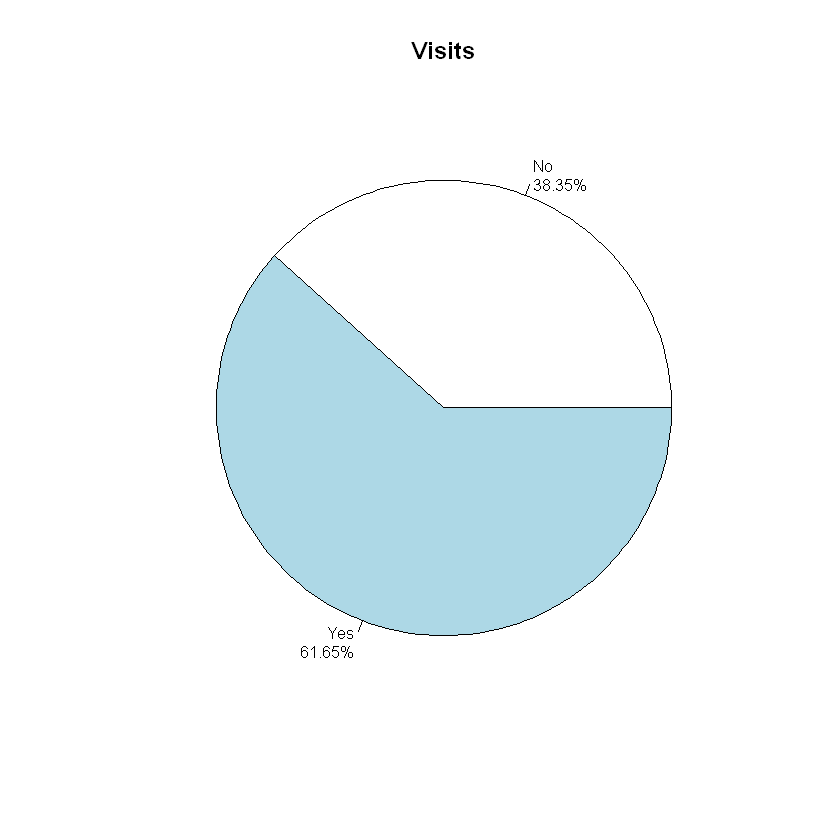

In [83]:
myPie("NonBounceVisit","Visits")

In [38]:
agg <- aggregate(cbind(Visits) ~ weeknumberbyyear + NonBounceVisit,df.factor,sum)
agg$week <- ifelse(agg$weeknumberbyyear=="2017-01",54,as.numeric(substr(agg$weeknumberbyyear,6,7)))

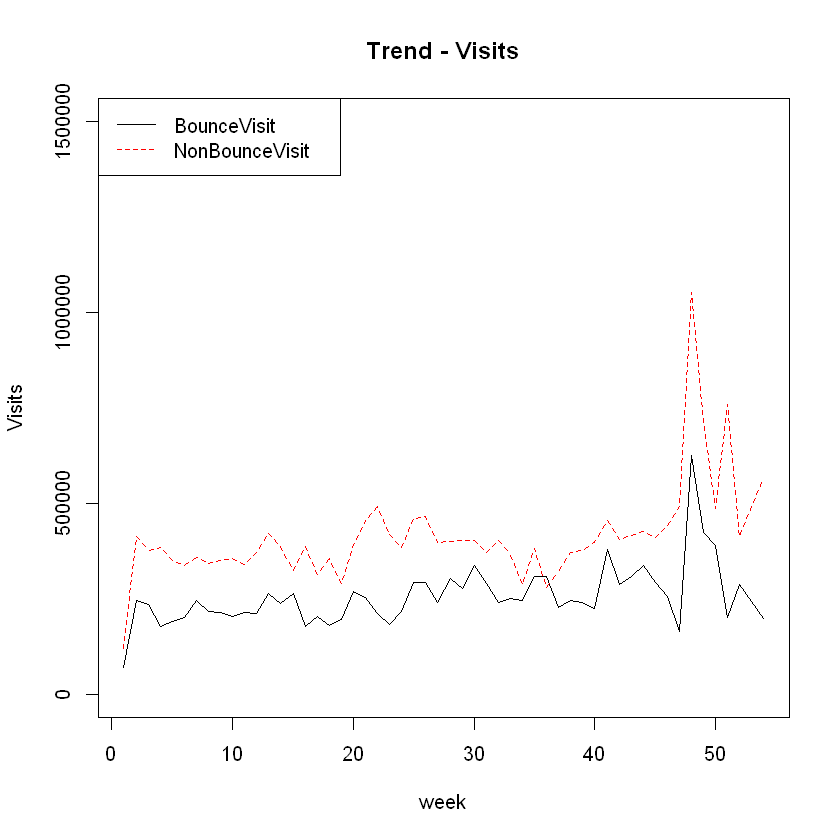

In [39]:
plot(Visits~week,filter(agg,NonBounceVisit=="No"),type='l',col=1,lty=1,ylim=c(0,1.5e+06),main="Trend - Visits",ylab="Visits")
lines(Visits~week,filter(agg,NonBounceVisit=="Yes"),col=2,lty=2,ylim=c(0,9e+05))
legend("topleft",col=c(1,2),lty=c(1,2),c("BounceVisit"，"NonBounceVisit"))

In [40]:
round(prop.table(xtabs(Visits ~ NonBounceVisit + TrafficSourceType,df.factor),2),digits=4)*100

              TrafficSourceType
NonBounceVisit Affiliates Direct Display Email Organic Others   PPC Referrals
           No       44.56  31.72   41.09 30.25   45.14  38.45 44.94     43.09
           Yes      55.44  68.28   58.91 69.75   54.86  61.55 55.06     56.91

In [41]:
round(prop.table(xtabs(Visits ~ NonBounceVisit + VisitorType,df.factor),2),digits=4)*100

              VisitorType
NonBounceVisit   New Returning
           No  49.51     30.31
           Yes 50.49     69.69

In [42]:
round(prop.table(xtabs(Visits ~ NonBounceVisit + Device,df.factor),2),digits=4)*100

              Device
NonBounceVisit Desktop Mobile Tablet
           No    30.08  47.76  37.55
           Yes   69.92  52.24  62.45

In [ ]:
## note: 
## bouncevisit followed the same trend of normal visit
## bouncevisit generate zero order/revenue
## new visitor: 50% bounce visit vs returnig user: 30%
## mobile: 48% bounce visit, which explained the low CoR

In [ ]:
#Product Overview
#Q: What is driving mobile device Conversion Rate compared to other Devices? What are you recommendations for the Product Team? 
#Q: In Jan-17 the Product Team will implement a new checkout feature that is expected to improve mobile Conversion Rate by 5%. What is the expected impact on Revenue of this project? 
#Q: Please outline your strategy to optimize Farfetch Conversion Rate for 2017. 
#       What are the areas of greatest improvement opportunity? 
#       Where the Product Team should focus?
#       Please present at least 5 projects and the value VisitWithAddtoWishlistYes associated with each one.  


In [ ]:
#logistic regression to build model of conversion rate

In [43]:
 myData <- filter(df.factor,NonBounceVisit=="Yes")
myData$ynOrders <- ifelse(myData$Orders>0,1,0)
myData$ynOrders <- factor(myData$ynOrders,levels=c(0,1),labels=c("No","Yes"))

# remove 3 variables will cause glm overfit
myFormula <-  ynOrders ~  week + TrafficSourceType + Device + VisitorType + HomePageWasVisited + ProductPageWasVisited + VisitToProductAfterListing + SiteSearchWasUsed + VisitWithAddtoBag + VisitWithAddtoWishlist + ShippingAddressWasVisited + PaymentPageWasVisited


In [44]:
fit <- glm(myFormula,data = myData, family = binomial())

In [45]:
summary(fit)


Call:
glm(formula = myFormula, family = binomial(), data = myData)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7220  -0.9042  -0.6314   1.1960   2.5009  

Coefficients:
                                Estimate Std. Error z value Pr(>|z|)    
(Intercept)                   -2.2618285  0.0316589 -71.444  < 2e-16 ***
week                           0.0013064  0.0003809   3.430 0.000603 ***
TrafficSourceTypeDirect        0.6022493  0.0200977  29.966  < 2e-16 ***
TrafficSourceTypeDisplay      -0.3420183  0.0274744 -12.449  < 2e-16 ***
TrafficSourceTypeEmail         0.1763875  0.0232888   7.574 3.62e-14 ***
TrafficSourceTypeOrganic       0.0425332  0.0228178   1.864 0.062316 .  
TrafficSourceTypeOthers       -0.4262781  0.0279008 -15.278  < 2e-16 ***
TrafficSourceTypePPC           0.0528642  0.0224855   2.351 0.018721 *  
TrafficSourceTypeReferrals    -0.4603019  0.0286542 -16.064  < 2e-16 ***
DeviceMobile                  -0.1581788  0.0132104 -11.974  < 2e-16 ***


In [46]:
round(exp(coef(fit)),digits=4)

(Intercept)                          week 
                       0.1042                        1.0013 
      TrafficSourceTypeDirect      TrafficSourceTypeDisplay 
                       1.8262                        0.7103 
       TrafficSourceTypeEmail      TrafficSourceTypeOrganic 
                       1.1929                        1.0435 
      TrafficSourceTypeOthers          TrafficSourceTypePPC 
                       0.6529                        1.0543 
   TrafficSourceTypeReferrals                  DeviceMobile 
                       0.6311                        0.8537 
                 DeviceTablet          VisitorTypeReturning 
                       0.7163                        1.5181 
        HomePageWasVisitedYes      ProductPageWasVisitedYes 
                       1.2670                        2.9704 
VisitToProductAfterListingYes          SiteSearchWasUsedYes 
                       1.2033                        0.7298 
         VisitWithAddtoBagYes     VisitWithAddtoWishlistYes 
                       1.1651                        0.5017 
 ShippingAddressWasVisitedYes      PaymentPageWasVisitedYes 
                       0.7893                        2.0823

In [47]:
fit.od<- glm(myFormula,data = myData, family = quasibinomial())
pchisq(summary(fit.od)$dispersion * fit$df.residual,fit$df.residual,lower=F)

[1] 1

In [ ]:
## note:
## drive conversion rate per more: TrafficSourceTypeEmail 1.20x, VisitWithAddtoBagYes 1.24x,
##                     VisitToProductAfterListing 1.25X, HomePageWasVisited 1.30X,VistorTypeReturning 1.54X,
##                     TrafficSourceType-Direct 1.83X,PaymentPageWasVisited 2.19X,ProductPageWasVisited 3.23X
## drive conversion rate per less: VisitWithAddtoWishlistYes 0.52x, TrafficSourceTypeReferrals 0.63x,TrafficSourceTypeOthers 0.65x,
##                        TrafficSourceTypeDisplay 0.71x,DeviceTablet 0.71x,SiteSearchWasUsedYes 0.73x,
##                        ShippingAddressWasVisitedYes 0.81x,DeviceMobile 0.85x  

In [ ]:
#logistics regression filter on mobile

In [48]:
myData.m <- filter(myData,Device=="Mobile")

# remove 3 variables will cause glm overfit
myFormula.m <-  ynOrders ~  week + TrafficSourceType + VisitorType + HomePageWasVisited + ProductPageWasVisited + VisitToProductAfterListing + SiteSearchWasUsed + VisitWithAddtoBag + VisitWithAddtoWishlist + ShippingAddressWasVisited + PaymentPageWasVisited


In [49]:
fit.m <- glm(myFormula.m,data = myData.m, family = binomial())

In [50]:
summary(fit.m)


Call:
glm(formula = myFormula.m, family = binomial(), data = myData.m)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.6437  -0.8918  -0.6300   1.1930   2.4678  

Coefficients:
                                Estimate Std. Error z value Pr(>|z|)    
(Intercept)                   -2.2775999  0.0499706 -45.579  < 2e-16 ***
week                           0.0025251  0.0006374   3.962 7.44e-05 ***
TrafficSourceTypeDirect        0.5874847  0.0329055  17.854  < 2e-16 ***
TrafficSourceTypeDisplay      -0.4278252  0.0465530  -9.190  < 2e-16 ***
TrafficSourceTypeEmail         0.2323542  0.0373099   6.228 4.73e-10 ***
TrafficSourceTypeOrganic      -0.0031182  0.0377874  -0.083   0.9342    
TrafficSourceTypeOthers       -0.4914690  0.0467913 -10.503  < 2e-16 ***
TrafficSourceTypePPC          -0.0725601  0.0376287  -1.928   0.0538 .  
TrafficSourceTypeReferrals    -0.4962505  0.0466779 -10.631  < 2e-16 ***
VisitorTypeReturning           0.3796791  0.0204953  18.525  < 2e-16 

In [51]:
round(exp(coef(fit.m)),digits=4)

(Intercept)                          week 
                       0.1025                        1.0025 
      TrafficSourceTypeDirect      TrafficSourceTypeDisplay 
                       1.7995                        0.6519 
       TrafficSourceTypeEmail      TrafficSourceTypeOrganic 
                       1.2616                        0.9969 
      TrafficSourceTypeOthers          TrafficSourceTypePPC 
                       0.6117                        0.9300 
   TrafficSourceTypeReferrals          VisitorTypeReturning 
                       0.6088                        1.4618 
        HomePageWasVisitedYes      ProductPageWasVisitedYes 
                       1.1912                        3.0112 
VisitToProductAfterListingYes          SiteSearchWasUsedYes 
                       1.1589                        0.7149 
         VisitWithAddtoBagYes     VisitWithAddtoWishlistYes 
                       1.1093                        0.4622 
 ShippingAddressWasVisitedYes      PaymentPageWasVisitedYes 
                       0.7799                        2.0072

In [54]:
# contingence table of VisitWithAddtoWishlist
round(prop.table(xtabs(Visits ~VisitWithAddtoWishlist + ynOrders,myData),1),digits=4)* 100

                      ynOrders
VisitWithAddtoWishlist    No   Yes
                   No  37.41 62.59
                   Yes 62.44 37.56

In [ ]:
## note:
## VisitWithAddtoWishlist saw low converation

In [85]:
df.m <- filter(df.factor,Device=="Mobile")

In [102]:
m.Visits <- sum(df.m$Visits)
m.CoR <- sum(df.m$Orders)/sum(df.m$Visits)*100
m.AoV <- sum(df.m$Revenue)/sum(df.m$Orders)
# increase mobile conversion by 5%, estimate revenue increase
cat("5% improve on 2016 annual conversion rate, new Mobile Converaton Rate(%):")
round(m.CoR * 1.05,digits=2)
cat("Mobile Average Order Value (same with 2016):")
round(m.AoV,digits=2)
cat("Revenue Increase:")
round(sum(df.m$Revenue) * 0.05,digits=0)

5% improve on 2016 annual conversion rate, new Mobile Converaton Rate(%):

[1] 0.68

Mobile Average Order Value (same with 2016):

[1] 663.14

Revenue Increase:

[1] 3322649